<center><h1>MIMO CSTR Case Study</h1></center>


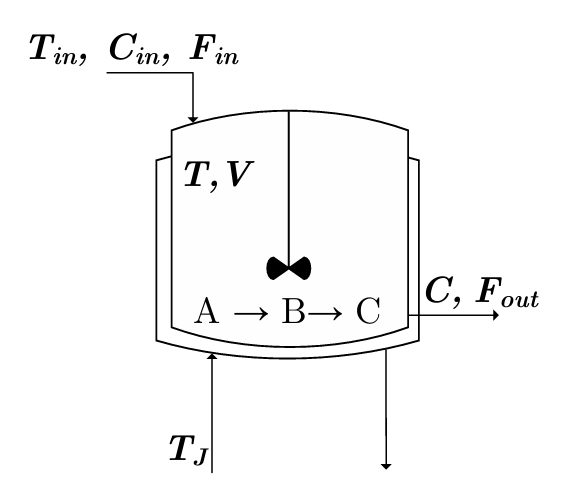

The following generalized reactions take place in the reactor, where B is the desired component 
$$  A \xrightarrow{r_a} B \xrightarrow{r_b} C  $$

We have the following system of ODEs:

$$\frac{dC_A}{dt} = \frac{F_{in}C_{A,in} - F_{out}C_A}{V} - r_a$$

$$ \frac{dC_B}{dt} = r_a - r_b - \frac{F_{out}C_B}{V} $$

$$ \frac{dC_C}{dt} = r_b - \frac{F_{out}C_C}{V} $$

$$ \frac{dT}{dt} = \frac{F_{in}(T_f - T)}{V} + \frac{\Delta H_a}{\rho C_p} r_A + \frac{\Delta H_b}{\rho C_p} r_B + \frac{UA}{V \rho C_p} (T_c - T) $$

$$ \frac{dV}{dt} = F_{in} - F_{out} $$

The three observed states of the reactor are the 1. Concentration of B $C_B$ 2. Reactor Temperature $T$ 3. Volume $V$ => Define the state vector x $x = [C_B, T, V]$

We desire a policy that maps these to the action space, comprising the 1. Cooling jacket temperature $T_c$ 2. Inlet flow rate $F_{in}$ => Define the control vector $u = [T_c, F_{in}]$

This creates a system with two PID controllers:

1. First controller pairs $T_c$ and $C_B$
2. Second controller pairs $F_{in}$ and $V$

The pairing was decided using a Relative Gain Array (RGA). This is additive measurement noise on all states of the CSTR. 

Note*: The PID controllers are not truely independent in a strict sense since the reactor is a coupled, nonlinear system:

* Changes in $T_c$ affects reaction rates, which in turn can influence $C_B$ and even the rate of volume change
* Changing $F_{in}$ affects residence time and concentrations, which can also alter temperature dynamics and thus indirectly affect how the first controller behaves

## Section 1: Model Testing

### Part 1: CSTR Model Dynamics

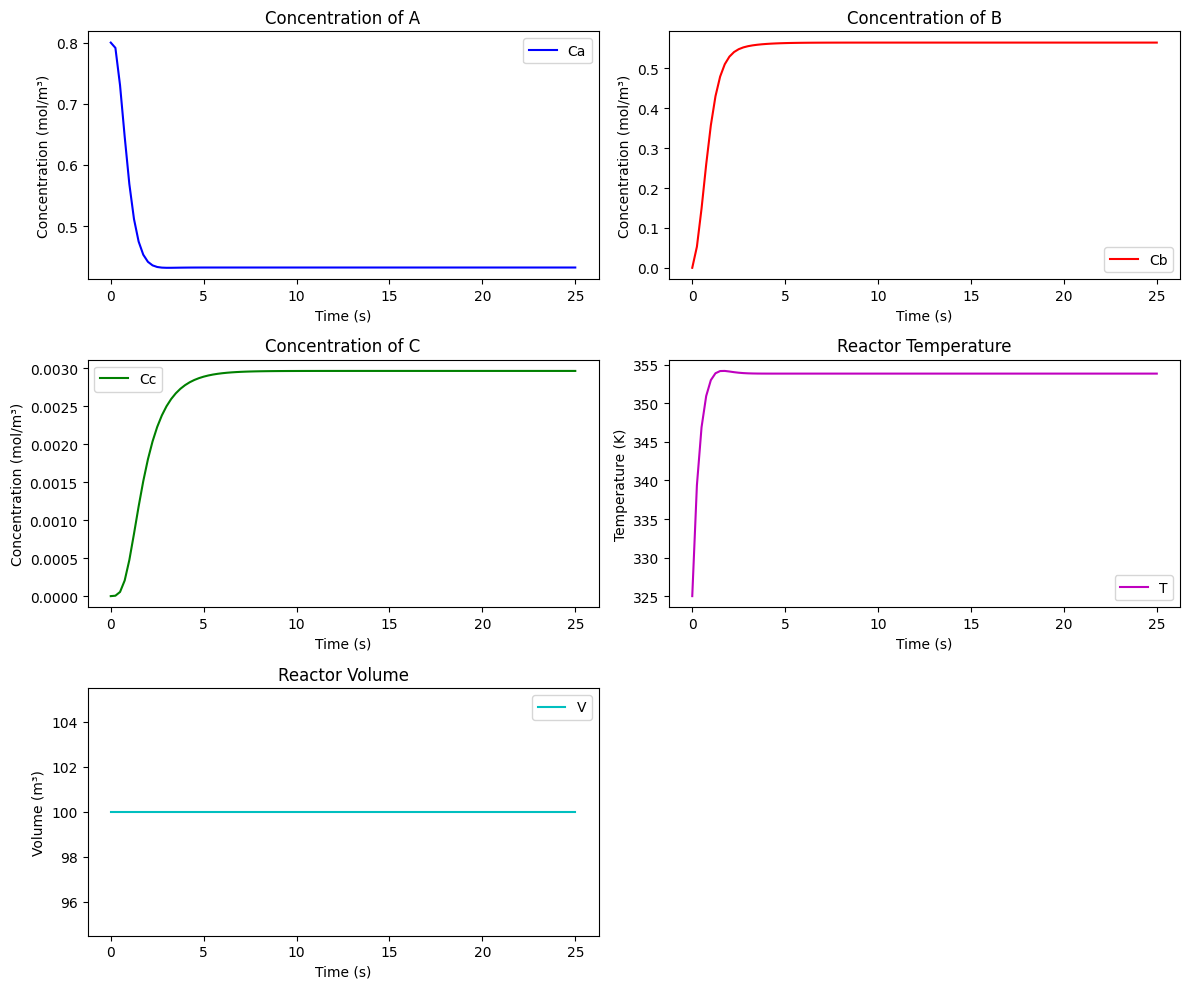

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from CSTR_model_plus import cstr_dynamics

# Define initial conditions and parameters
# State vector: [Ca, Cb, Cc, T, V]
x0 = [0.8, 0.0, 0.0, 325.0, 100.0]

# Control inputs: [Tc, Fin]
u = [350.0, 100.0]

# Feed conditions 
Tf = 350    # Feed temperature (K)
Caf = 1.0   # Feed concentration of A (mol/m^3)

# Define the time span for simulation (e.g., 0 to 100 minutes)
t = np.linspace(0, 25, 101)  # 1001 points => dt=0.1 minute

# Simulate the reactor dynamics using odeint
x = odeint(cstr_dynamics, x0, t, args=(u, Tf, Caf))

# Extract state variables from the simulation result
Ca = x[:, 0]
Cb = x[:, 1]
Cc = x[:, 2]
T  = x[:, 3]
V  = x[:, 4]

# Plot the results
plt.figure(figsize=(12, 10))

plt.subplot(3, 2, 1)
plt.plot(t, Ca, 'b-', label='Ca')
plt.xlabel('Time (s)')
plt.ylabel('Concentration (mol/m³)')
plt.title('Concentration of A')
plt.legend()

plt.subplot(3, 2, 2)
plt.plot(t, Cb, 'r-', label='Cb')
plt.xlabel('Time (s)')
plt.ylabel('Concentration (mol/m³)')
plt.title('Concentration of B')
plt.legend()

plt.subplot(3, 2, 3)
plt.plot(t, Cc, 'g-', label='Cc')
plt.xlabel('Time (s)')
plt.ylabel('Concentration (mol/m³)')
plt.title('Concentration of C')
plt.legend()

plt.subplot(3, 2, 4)
plt.plot(t, T, 'm-', label='T')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (K)')
plt.title('Reactor Temperature')
plt.legend()

plt.subplot(3, 2, 5)
plt.plot(t, V, 'c-', label='V')
plt.xlabel('Time (s)')
plt.ylabel('Volume (m³)')
plt.title('Reactor Volume')
plt.legend()

plt.tight_layout()
plt.show()


### Part 2: PID controller test

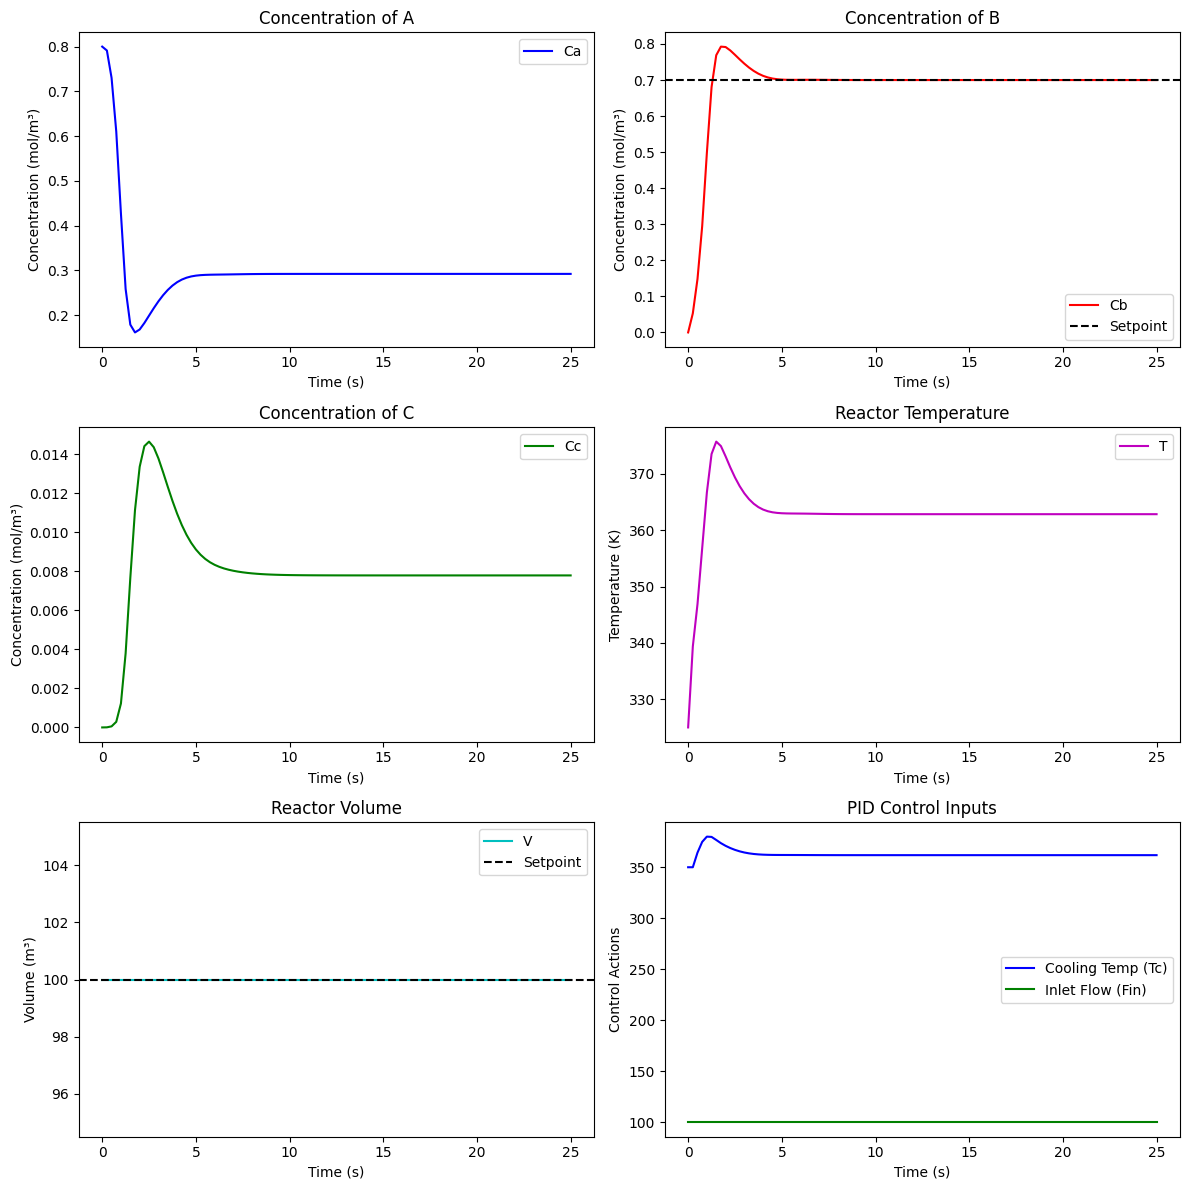

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from CSTR_model_plus import cstr_dynamics, PID_velocity 

# PID Gains 
Kp_Cb, Ki_Cb, Kd_Cb = 3.09, 0.03, 0.83
Kp_V, Ki_V, Kd_V = 0.84, 1.85, 0.08
Ks = [Kp_Cb, Ki_Cb, Kd_Cb, Kp_V, Ki_V, Kd_V]  # Combined gain array

# Initial Conditions
x0 = [0.8, 0.0, 0.0, 325.0, 100.0]  # [Ca, Cb, Cc, T, V]
u0 = [350.0, 100.0]  # Initial control inputs: [Tc, Fin]
Tf, Caf = 350, 1.0  # Feed conditions

# Setpoints
Cb_setpoint = 0.7   # Desired product B concentration
V_setpoint = 100.0  # Desired reactor volume

# Simulation Setup
t = np.linspace(0, 25, 101)  # 25 seconds
dt = t[1] - t[0]  # Time step

# Storage for results
states = np.zeros((len(t), 5))  # State variables
Tc_values, Fin_values = np.zeros(len(t)), np.zeros(len(t))  # Control actions

# PID Error History (needed for velocity PID)
e_history = [np.array([0, 0]), np.array([0, 0])]  # Store at least two previous errors
u_history = [u0, u0]  # Store previous control actions

# Simulation Loop
x = x0
for i in range(len(t)):
    # Store current state
    states[i, :] = x
    
    # Compute current errors for PID (difference from setpoint)
    e_now = np.array([Cb_setpoint - x[1], V_setpoint - x[4]])

    # Compute PID control action using velocity form
    if i < 2:
        control_action = u_history[-1]  
    else:
        control_action = PID_velocity(Ks, e_now, e_history, u_history, dt)

    # Apply physical constraints
    Tc, Fin = np.clip(control_action[0], 290, 450), np.clip(control_action[1], 95, 105)

    # Store control history
    e_history.append(e_now)
    u_history.append([Tc, Fin])
    if len(e_history) > 3:
        e_history.pop(0)
        u_history.pop(0)

    # Apply updated controls
    Tc_values[i], Fin_values[i] = Tc, Fin

    # Simulate next time step
    u = [Tc, Fin]
    x = odeint(cstr_dynamics, x, [0, dt], args=(u, Tf, Caf))[-1]

# Extract states
Ca, Cb, Cc, T, V = states.T

# Plot Results
plt.figure(figsize=(12, 12))

plt.subplot(3, 2, 1)
plt.plot(t, Ca, label='Ca', color='b')
plt.xlabel('Time (s)')
plt.ylabel('Concentration (mol/m³)')
plt.title('Concentration of A')
plt.legend()

plt.subplot(3, 2, 2)
plt.plot(t, Cb, label='Cb', color='r')
plt.axhline(y=Cb_setpoint, color='k', linestyle='--', label='Setpoint')
plt.xlabel('Time (s)')
plt.ylabel('Concentration (mol/m³)')
plt.title('Concentration of B')
plt.legend()

plt.subplot(3, 2, 3)
plt.plot(t, Cc, label='Cc', color='g')
plt.xlabel('Time (s)')
plt.ylabel('Concentration (mol/m³)')
plt.title('Concentration of C')
plt.legend()

plt.subplot(3, 2, 4)
plt.plot(t, T, label='T', color='m')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (K)')
plt.title('Reactor Temperature')
plt.legend()

plt.subplot(3, 2, 5)
plt.plot(t, V, label='V', color='c')
plt.axhline(y=V_setpoint, color='k', linestyle='--', label='Setpoint')
plt.xlabel('Time (s)')
plt.ylabel('Volume (m³)')
plt.title('Reactor Volume')
plt.legend()

plt.subplot(3, 2, 6)
plt.plot(t, Tc_values, label='Cooling Temp (Tc)', color='b')
plt.plot(t, Fin_values, label='Inlet Flow (Fin)', color='g')
plt.xlabel('Time (s)')
plt.ylabel('Control Actions')
plt.title('PID Control Inputs')
plt.legend()

plt.tight_layout()
plt.show()


### Part 3: Setpoint Tracking Problem

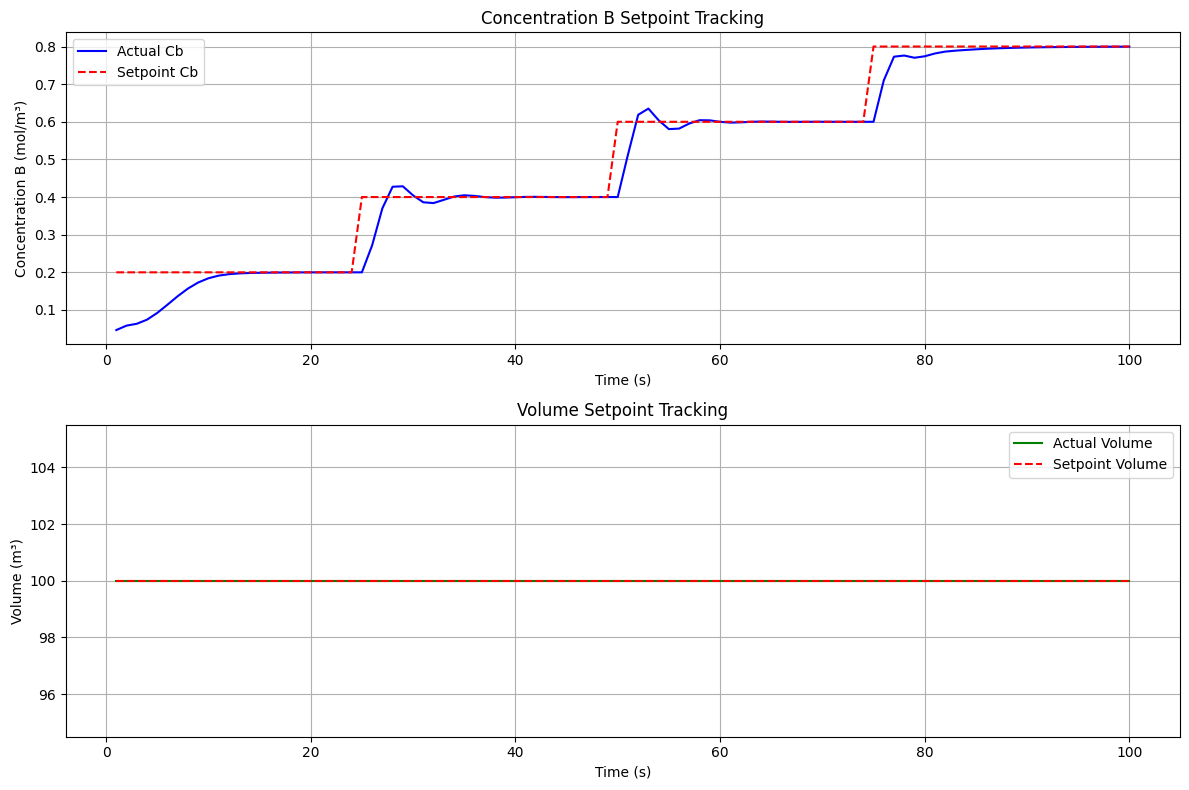

Simulation completed with setpoint tracking


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from CSTR_model_plus import CSTRRLEnv, PID_velocity

def main():
    # Create environment with setpoint tracking
    env = CSTRRLEnv(
        simulation_steps=100,
        dt = 1.0,
        uncertainty_level=0.0,
        noise_level=0.0,
        transport_delay_steps=0,
        actuator_delay_steps=0,
        enable_disturbances=False
    )

    # Define setpoints for tracking
    setpoints_Cb  = [0.2, 0.4, 0.6, 0.8]  # Concentration B setpoints
    setpoints_V   = [100, 100, 100, 100]  # Volume setpoints
    setpoint_durations = [25, 25, 25, 25] # 25 timesteps per setpoint

    # Reset environment with custom setpoints
    obs, _ = env.reset(options={
        'setpoints_Cb': setpoints_Cb,
        'setpoints_V': setpoints_V,
        'setpoint_durations': setpoint_durations
    })

    # Fixed PID gains for this example
    fixed_pid_gains = np.array([25., 0.7791, 0.0200, 0.7432, 0.7561, 0.0977])
    
    action = np.zeros(6) # Normalized action spaces [-1, 1]

    # Convert fixed gains to normalized action space
    action = 2.0 * (fixed_pid_gains - env.pid_lower) / (env.pid_upper - env.pid_lower) - 1.0

    # Run simulation with fixed controller
    done = False
    rewards = []
    cb_values = [] 
    cb_setpoints = []
    v_values = []
    v_setpoints = []
    time_values = []

    while not done:
        # Take a step with fixed PID controller
        obs, reward, done, _, info = env.step(action)

        # Store data for plotting
        rewards.append(reward)
        cb_values.append(info['true_state'][1])  # Concentration B
        cb_setpoints.append(info['setpoint_Cb'])
        v_values.append(info['true_state'][4])   # Volume
        v_setpoints.append(info['setpoint_V'])
        time_values.append(len(cb_values))
        
        # # Render the current state
        # env.render()

    # Plot results after simulation
    plt.figure(figsize=(12, 8))
    
    # Plot Concentration B
    plt.subplot(2, 1, 1)
    plt.plot(time_values, cb_values, 'b-', label='Actual Cb')
    plt.plot(time_values, cb_setpoints, 'r--', label='Setpoint Cb')
    plt.legend()
    plt.title('Concentration B Setpoint Tracking')
    plt.xlabel('Time (s)')
    plt.ylabel('Concentration B (mol/m³)')
    plt.grid(True)
    
    # Plot Volume
    plt.subplot(2, 1, 2)
    plt.plot(time_values, v_values, 'g-', label='Actual Volume')
    plt.plot(time_values, v_setpoints, 'r--', label='Setpoint Volume')
    plt.legend()
    plt.title('Volume Setpoint Tracking')
    plt.xlabel('Time (s)')
    plt.ylabel('Volume (m³)')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

    # Clean up
    env.close()

    print("Simulation completed with setpoint tracking")

if __name__ == "__main__":
    main()

## Section 2: PID Controllers Parameter Tuning

### Part 1: Static PID Gain Approach

This approach optimizes the static PID gains for the CSTR control system using differential evolution. The goal is to find optimal PID gains that minimize error when tracking a setpoint schedule. 

In [5]:
from static_pid_gain import StaticPIDOptimizer, run_optimization

if __name__ == "__main__":
    from CSTR_model_plus import CSTRRLEnv

    # Create environment with minimal noise/disturbance/noise for optimization
    env = CSTRRLEnv(
        simulation_steps=25*5,
        dt=1.0,
        uncertainty_level=0.0,     # No uncertainty
        noise_level=0.0,           # No measurement noise
        actuator_delay_steps=0,    # No actuator delay
        transport_delay_steps=0,   # No transport delay
        enable_disturbances=False  # No disturbances
    )

    # Run optimization
    optimal_gains = run_optimization(env, maxiter=30, popsize=15)

    print("Optimization complete.")

Starting optimization with 30 iterations and population size 15
differential_evolution step 1: f(x)= 0.2704660026152467
differential_evolution step 2: f(x)= 0.2704660026152467
differential_evolution step 3: f(x)= 0.2704660026152467
differential_evolution step 4: f(x)= 0.2668539916176404
differential_evolution step 5: f(x)= 0.2668539916176404
differential_evolution step 6: f(x)= 0.2668539916176404
differential_evolution step 7: f(x)= 0.2668539916176404
differential_evolution step 8: f(x)= 0.23560541783271693
differential_evolution step 9: f(x)= 0.23560541783271693
differential_evolution step 10: f(x)= 0.23560541783271693
differential_evolution step 11: f(x)= 0.23560541783271693
differential_evolution step 12: f(x)= 0.23560541783271693
differential_evolution step 13: f(x)= 0.23560541783271693
differential_evolution step 14: f(x)= 0.23560541783271693
differential_evolution step 15: f(x)= 0.23383905440634237
differential_evolution step 16: f(x)= 0.23383905440634237
differential_evolution s

Loaded data from ./results/optimal_pid_gains.npy:
 [2.50000000e+01 7.32644787e-01 2.00000000e-02 3.53409552e-01
 2.58712863e-01 2.72371291e-01]


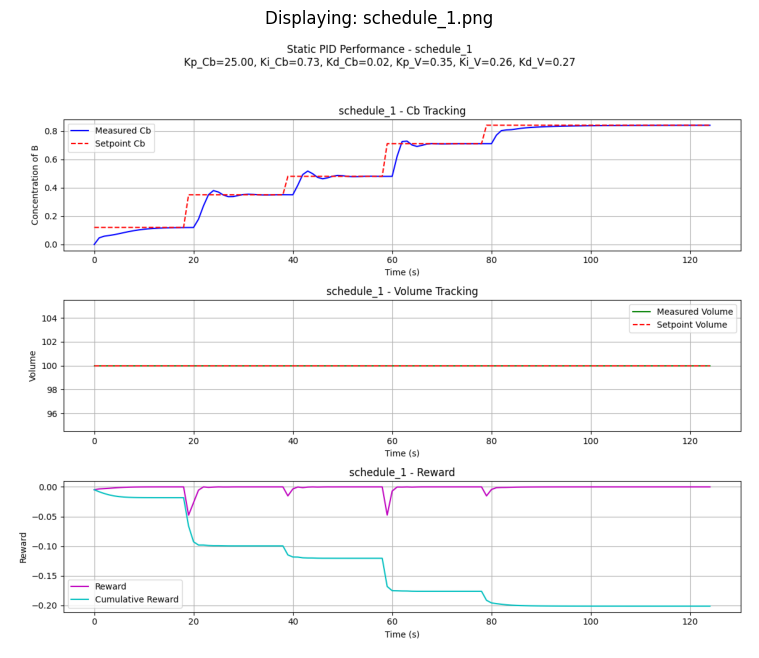

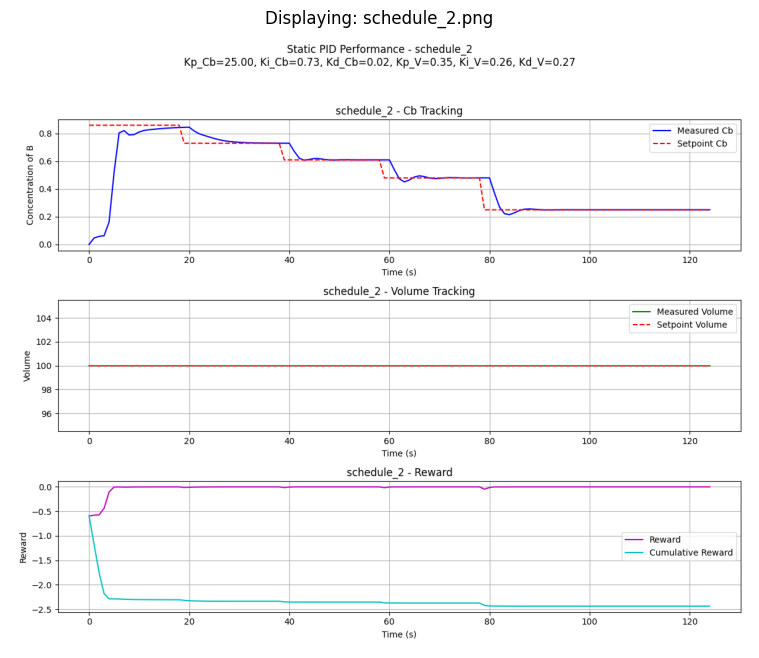

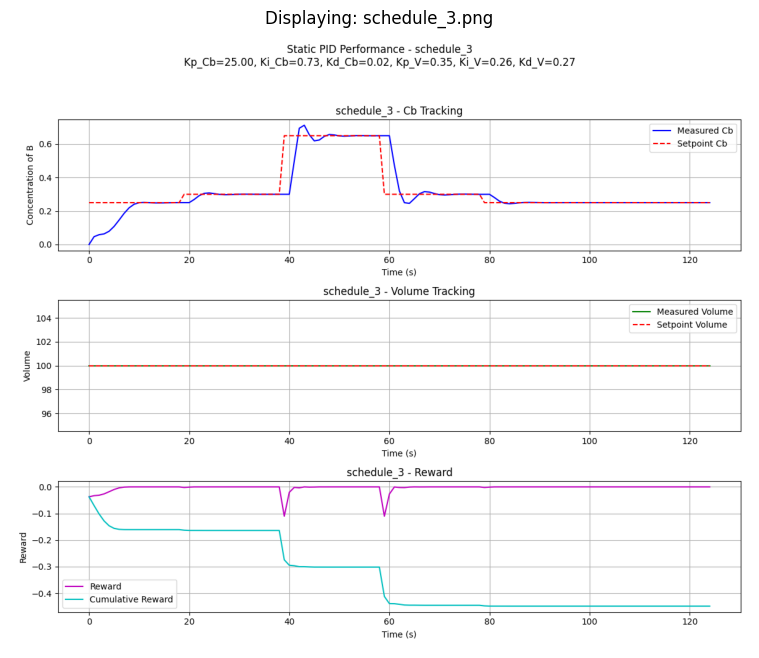

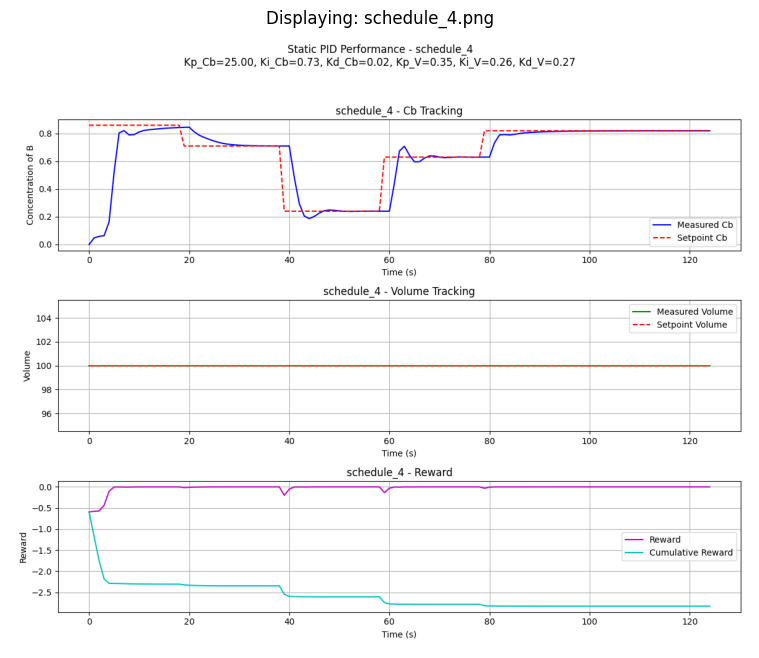

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import os

def load_npy_file(npy_path):
    if os.path.exists(npy_path):
        data = np.load(npy_path)
        print(f"Loaded data from {npy_path}:\n", data)
        return data
    else:
        print(f"Error: File {npy_path} not found")
        return None
    
def display_png_file(png_path):
    if os.path.exists(png_path):
        img = plt.imread(png_path)
        plt.figure(figsize=(12,8))
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Displaying: {os.path.basename(png_path)}")
        plt.show()
    else:
        print(f"Eror: File {png_path} not found.")

if __name__ == "__main__":
    npy_file_path = "./results/optimal_pid_gains.npy"
    load_npy_file(npy_file_path)
    for i in range(4):
        png_file_path = f"./results/plots/schedule_{i+1}.png"
        display_png_file(png_file_path) 
        


### Part 2: Adaptive PID Control (Conventional Approach)



In [7]:
# Task 0

## Section 3. Reinforcement Learning for Dynamic Tuning of PID Controllers

### Part 0: Historical (Simulation) Data Generation

Key Assumptions:

1. In real-world chemical process industries, before a plant is built, extensive modeling, design, and simulations are conducted to ensure:
    * Mass and energy balances are well-understood
    * Reaction kinetics and thermodynamics are characterized
    * Control strategies are designed for stable operation
    * Dynamic process models are validated using historical lab/pilot plant data

Conclusion from 1: If the plant is well-designed and commisioned, then a reasonably accurate model exists. However, uncertainties and disturbances (e.g., catalyst deactivation, equipment aging) always exist, which is why adaptive control and RL-based tuning can be useful.

2. If a reliable model exists, we can use it to simulate vast amounts of data before applying RL in real plant. Advantages: 
    * Safe exploration -- RL does not need to interact with the real plant, avoiding unsafe operations. 
    * Large-scale data generation -- We can simulate disturbances, different setpoints, and failure modes to cover a wide range of scenarios.
    * Better Generalization -- The RL agent can learn from highly diverse training data rather than being constrained by limited real-world trials.
    * Efficient Deployment -- Once trained on simulated data, the RL-based PID tuning model can be fine-tuned online with minimal interaction. 



Additional Comments on the offline dataset

* Essential Data for Offline RL:
    * Transitions: (state, action, reward, next_state, done) tuples
    * Metadata: Actual PID gains, setpoints, and any relevant simulation parameters
    * Coverage: The dataset should span nominal operating conditions, disturbances, and various setpoint transitions to train an RL agent robustly

* Plots:
    * Episode Reward Curves: To visualize performance over time
    * Action Distribtions: To verify that the exploration strategy covers a wide range of actions
    * State vs. Setpoint Trajectories: To ensure that the data reflects diverse tracking behaviors
    * Summary Statics: Such as means and variances of key variables to provide an overall view of data diversity

* Range of Spectrum:
    * Dataset includes episodes under normal operation, under disturbances, and with different setpoint profiles (increasing, decreasing, peak, valley, constant). => This helps the offline RL algorithm learn a robust policy that generalizes across operating conditions


In [9]:
from gen_sim_data import generate_diverse_dataset, DataGenerator

if __name__ == "__main__":
    from CSTR_model_plus import CSTRRLEnv
    
    # Create environment with realistic conditions
    env = CSTRRLEnv(
        simulation_steps=100,
        dt=1.0,
        uncertainty_level=0.00,     # Add some uncertainty for realism
        noise_level=0.00,           # Add some noise for realism
        actuator_delay_steps=0,     # Add realistic delays
        transport_delay_steps=0,
        enable_disturbances=False   # Enable disturbances for robustness
    )
    
    # Generate dataset with default parameters
    dataset = generate_diverse_dataset(env, n_episodes=40)
    
    print("Dataset generation complete.")

Generating diverse dataset with 40 total episodes
Generating 10 episodes with 'random' strategy


100%|██████████| 10/10 [00:00<00:00, 18.45it/s]


Generated dataset with 1000 transitions from 10 episodes
Generating 10 episodes with 'static_pid' strategy


100%|██████████| 10/10 [00:00<00:00, 14.02it/s]


Generated dataset with 1000 transitions from 10 episodes
Generating 10 episodes with 'decaying' strategy


100%|██████████| 10/10 [00:00<00:00, 14.27it/s]


Generated dataset with 1000 transitions from 10 episodes
Generating 10 episodes with 'mixed' strategy


100%|██████████| 10/10 [00:00<00:00, 18.92it/s]


Generated dataset with 1000 transitions from 10 episodes
Combined 4 datasets with a total of 4000 transitions
Dataset contains 4000 transitions from 40 episodes
Reward statistics:
  Mean: -0.1101
  Std: 0.1389
  Min: -0.6251
  Max: -0.0000
Action statistics:
  Action 0 - Mean: 0.5628, Std: 0.5648
  Action 1 - Mean: 0.0130, Std: 0.4336
  Action 2 - Mean: 0.1318, Std: 0.4391
  Action 3 - Mean: 0.1241, Std: 0.4404
  Action 4 - Mean: 0.3154, Std: 0.4877
  Action 5 - Mean: 0.0429, Std: 0.4322
PID gains statistics:
  Kp_Cb - Mean: 18.4425, Std: 8.4723
  Ki_Cb - Mean: 10.1297, Std: 4.3365
  Kd_Cb - Mean: 5.6676, Std: 2.1912
  Kp_V - Mean: 0.5621, Std: 0.2202
  Ki_V - Mean: 1.3154, Std: 0.4877
  Kd_V - Mean: 0.5262, Std: 0.2139
Unique Cb setpoints: [0.15       0.21367712 0.23800614 0.25       0.29900499 0.3
 0.31895557 0.35       0.4        0.45       0.47878207 0.48
 0.50346609 0.50502272 0.51043078 0.55       0.6        0.65
 0.66020658 0.68       0.7        0.70329414 0.75       0.8243409
 

In [10]:
import pickle

def print_dataset(file_path):
    with open(file_path, 'rb') as file:
        dataset = pickle.load(file)
    
    for key, value in dataset.items():
        print(f"{key}: {value}")

# Specify the file path
file_path = '/home/jzhao/work/nonlinear-multi-loop-CSTR-for-RL/data/offline_train_dataset.pkl'

# Print the dataset
print_dataset(file_path)

states: [[0.00000000e+00 3.25000000e+02 1.00000000e+02 ... 1.00000000e+02
  1.50000000e-01 1.00000000e+02]
 [0.00000000e+00 3.25000000e+02 1.00000000e+02 ... 1.00000000e+02
  1.50000000e-01 1.00000000e+02]
 [4.66206757e-02 3.17018712e+02 1.00000000e+02 ... 1.00000000e+02
  1.50000000e-01 1.00000000e+02]
 ...
 [8.35048794e-01 3.95365310e+02 1.00000000e+02 ... 1.00000000e+02
  4.00000000e-01 1.00000000e+02]
 [8.38457979e-01 3.94631446e+02 1.00000000e+02 ... 1.00000000e+02
  4.00000000e-01 1.00000000e+02]
 [8.41029498e-01 3.94422684e+02 1.00000000e+02 ... 1.00000000e+02
  4.00000000e-01 1.00000000e+02]]
actions: [[ 0.87106997  0.45926625  0.5554125   0.71313349 -0.99059947 -0.37977457]
 [ 0.07743472  0.65669368 -0.61150006  0.72809085  0.16811509  0.24871224]
 [-0.67016379  0.21138592  0.86306959 -0.05543699 -0.39884722 -0.0630051 ]
 ...
 [ 0.98278619  0.05035066 -0.0176362   0.31771721  0.67589568  0.10786377]
 [ 0.97596559 -0.06830084  0.11793221  0.17678992  0.49137715 -0.09990246]
 [ 

### Part 1: Particle Swarm Optimizer (PSO) + Control-Informed RL (CIRL)

* The Particle Swarm Optimization (PSO) algorithm is an optimization technique inspured by the collective behavior in flocks of birds or schools of fish. As an evolutionary algorithm, PSO mimics the way individuals (particles) in a group evolve their positions to collectively find an optimal solution. 

    In PSO:
    * Each particle represents a potential solution to the problem
    * Particles move through the solution space, guided by their own best-known position and the best-known position of their neighbors or the entire swarm
    * Over time, particle "evolve" by updating their positions and velocities, balancing exploration (searching new areas) and exploitation (focusing on promising areas).

This evolutionary process shares similarities with other EAs like genetic algorithms, in that it involves iteration and optimization based on a population of solutions, but it doesn't involve genetic operators like crossover or mutation. Instead, it focuses on social interaction and learning.

**CIRL Rollout**:

**Input:** Policy Parameters $ \theta $, Number of simulation timesteps $ n_s $, Discrete time environment $ f $  
**Output:** Cumulative Reward $ R $

1. $ s \gets s_0 $  # Reset observation to initial state  
2. $ R \gets 0 $  # Initialize cumulative reward  
3. **for** $ t = 0 $ **to** $ n_s - 1 $:  
    1. $ K_{p,t}, \tau_{i,t}, \tau_{d,t} \gets \pi_\theta(s_t) $  # Get current PID gains from policy  
    2. $ u_t \gets PID(K_{p,t}, \tau_{i,t}, \tau_{d,t}, e_t, e_{t-1}, e_{t-2}) $  # Use PID controller to output control input  
    3. $ x_{t+1}, r_t \gets f(u_t, x_t) $  # Take one timestep in the environment  
    4. $ s_{t+1} \gets [x_{t+1}, x_t, x^*_{t+1}] $  # Update observation vector  
    5. $ R \gets R + r_t $  
4. **return** $ R $  # Return cumulative reward


**Overall Process**

1. Initialization with PSO: Use PSO to find good initial policy parameters
2. Offline RL training: Fine-tune using the generated dataset
3. Online Adaptation: Further refine the policy with direct environment interaction
4. Evalaution: Compare performance against the baseline static PID approach


#### Step 1: PSO Initialization

In [1]:
# Create environment for PSO

# PSO works by iteratively:
# 1. Evaluating each particle (candidate policy)
# 2. Updating the personal and global best positions
# 3. Moving particles toward promising areas of the parameter space
from Train_PSO_CIRL import PSOCIRL
from CSTR_model_plus import CSTRRLEnv

env = CSTRRLEnv(
    simulation_steps=125,
    dt=1.0,
    uncertainty_level=0.0,     # No uncertainty for initial optimization
    noise_level=0.0,           # No noise for initial optimization
    actuator_delay_steps=0,    # No delays for initial optimization
    transport_delay_steps=0,
    enable_disturbances=False  # No disturbances for initial optimization
)

# Set up trainer
trainer = PSOCIRL(
    env=env,
    state_dim=env.observation_space.shape[0],
    action_dim=env.action_space.shape[0],
    action_high=env.action_space.high[0],
    device="cuda",
    num_particles=20,
    max_iterations=30,
    save_dir="./results/pso_cirl"
)

# Define setpoints for PSO training
setpoints_Cb = [0.3, 0.5, 0.7, 0.8, 0.9]
setpoints_V =  [100.0] * len(setpoints_Cb)
setpoint_durations = [25] * len(setpoints_Cb)

# Run PSO initialization
pso_policy = trainer.initialize_with_pso(
    setpoints_Cb=setpoints_Cb,
    setpoints_V=setpoints_V,
    setpoint_durations=setpoint_durations,
    verbose=True
)

Initializing CIRL policy with PSO...


  3%|▎         | 1/30 [00:01<00:42,  1.47s/it]

Iteration 1/30: Best Score = -9.9588, Mean Score = -11.5821


 17%|█▋        | 5/30 [00:08<00:44,  1.80s/it]

Iteration 5/30: Best Score = -8.5110, Mean Score = -8.5213


 33%|███▎      | 10/30 [00:17<00:36,  1.81s/it]

Iteration 10/30: Best Score = -8.5110, Mean Score = -9.0464


 50%|█████     | 15/30 [00:26<00:26,  1.76s/it]

Iteration 15/30: Best Score = -8.5110, Mean Score = -8.5110


 67%|██████▋   | 20/30 [00:35<00:18,  1.80s/it]

Iteration 20/30: Best Score = -8.5110, Mean Score = -8.5110


 83%|████████▎ | 25/30 [00:44<00:08,  1.74s/it]

Iteration 25/30: Best Score = -8.5110, Mean Score = -8.5110


100%|██████████| 30/30 [00:53<00:00,  1.77s/it]

Iteration 30/30: Best Score = -8.5110, Mean Score = -8.5110
PSO initialization completed in 53.01 seconds
Best policy found with score: -8.5110


#### Step 2: Offline RL Training

Once we have a good initial policy from PSO, we'll create a CIRL agent and train it on the offline dataset using offline_train function:

In [2]:
from Train_PSO_CIRL import PSOCIRL
# Create CIRL agent initialized with PSO policy
cirl_agent = trainer.create_cirl_agent(pso_policy)

# Train the agent on offline dataset
offline_stats = trainer.train_offline(
    agent = cirl_agent,
    dataset_path="./data/offline_train_dataset.pkl",
    n_updates = 20000,
    batch_size = 256,
    update_interval = 1000,
    verbose=True
)


Initializing CIRL agent with PSO policy parameters...
CIRL agent initialized with PSO policy
Starting offline training of CIRL agent...
Loaded dataset from ./data/offline_train_dataset.pkl with 4000 transitions
Loaded 4000 transitions into replay buffer (capacity: 5000)


Training CIRL: 100%|██████████| 20000/20000 [04:02<00:00, 82.63it/s, actor_loss=5.4538, critic_loss=0.7711]


Plotting training curves...
Offline training completed


#### Step 3: Online Fine-Tuning

After offline training, we further improve the agent through online fine-tuning. This step involves direct interaction with a more challenging environment:

Starting online fine-tuning of CIRL agent...


Episode 6/100 | Reward: -6.13 | Buffer: 600/100000 | Noise: 0.290:   6%|▌         | 6/100 [00:02<00:43,  2.15it/s] 


Evaluation at episode 5: Reward = -12.59, Steps = 100.0


Episode 10/100 | Reward: -12.39 | Buffer: 1000/100000 | Noise: 0.282:  10%|█         | 10/100 [00:09<02:34,  1.72s/it]


Evaluation at episode 10: Reward = -12.67, Steps = 100.0
Saved checkpoint to ./results/pso_cirl/fine_tuned/models/cirl_episode_10


Episode 15/100 | Reward: -17.30 | Buffer: 1500/100000 | Noise: 0.272:  15%|█▌        | 15/100 [00:18<02:54,  2.05s/it]


Evaluation at episode 15: Reward = -12.49, Steps = 100.0


Episode 20/100 | Reward: -4.47 | Buffer: 2000/100000 | Noise: 0.262:  20%|██        | 20/100 [00:27<02:46,  2.08s/it] 


Evaluation at episode 20: Reward = -12.54, Steps = 100.0
Saved checkpoint to ./results/pso_cirl/fine_tuned/models/cirl_episode_20


Episode 25/100 | Reward: -13.85 | Buffer: 2500/100000 | Noise: 0.252:  25%|██▌       | 25/100 [00:36<02:39,  2.12s/it]


Evaluation at episode 25: Reward = -12.58, Steps = 100.0


Episode 30/100 | Reward: -8.54 | Buffer: 3000/100000 | Noise: 0.242:  30%|███       | 30/100 [00:46<02:26,  2.10s/it] 


Evaluation at episode 30: Reward = -12.75, Steps = 100.0
Saved checkpoint to ./results/pso_cirl/fine_tuned/models/cirl_episode_30


Episode 35/100 | Reward: -16.52 | Buffer: 3500/100000 | Noise: 0.232:  35%|███▌      | 35/100 [00:55<02:17,  2.12s/it]


Evaluation at episode 35: Reward = -12.55, Steps = 100.0


Episode 40/100 | Reward: -6.19 | Buffer: 4000/100000 | Noise: 0.222:  40%|████      | 40/100 [01:04<02:06,  2.11s/it] 


Evaluation at episode 40: Reward = -12.61, Steps = 100.0
Saved checkpoint to ./results/pso_cirl/fine_tuned/models/cirl_episode_40


Episode 45/100 | Reward: -14.95 | Buffer: 4500/100000 | Noise: 0.212:  45%|████▌     | 45/100 [01:13<01:55,  2.10s/it]


Evaluation at episode 45: Reward = -12.63, Steps = 100.0


Episode 50/100 | Reward: -17.64 | Buffer: 5000/100000 | Noise: 0.202:  50%|█████     | 50/100 [01:23<01:47,  2.16s/it]


Evaluation at episode 50: Reward = -12.62, Steps = 100.0
Saved checkpoint to ./results/pso_cirl/fine_tuned/models/cirl_episode_50


Episode 55/100 | Reward: -4.86 | Buffer: 5500/100000 | Noise: 0.192:  55%|█████▌    | 55/100 [01:32<01:35,  2.13s/it] 


Evaluation at episode 55: Reward = -12.52, Steps = 100.0


Episode 60/100 | Reward: -4.68 | Buffer: 6000/100000 | Noise: 0.182:  60%|██████    | 60/100 [01:41<01:23,  2.08s/it] 


Evaluation at episode 60: Reward = -12.55, Steps = 100.0
Saved checkpoint to ./results/pso_cirl/fine_tuned/models/cirl_episode_60


Episode 65/100 | Reward: -21.80 | Buffer: 6500/100000 | Noise: 0.172:  65%|██████▌   | 65/100 [01:50<01:13,  2.09s/it]


Evaluation at episode 65: Reward = -12.49, Steps = 100.0


Episode 70/100 | Reward: -11.27 | Buffer: 7000/100000 | Noise: 0.162:  70%|███████   | 70/100 [01:59<01:02,  2.10s/it]


Evaluation at episode 70: Reward = -12.63, Steps = 100.0
Saved checkpoint to ./results/pso_cirl/fine_tuned/models/cirl_episode_70


Episode 75/100 | Reward: -10.15 | Buffer: 7500/100000 | Noise: 0.152:  75%|███████▌  | 75/100 [02:08<00:53,  2.13s/it]


Evaluation at episode 75: Reward = -12.50, Steps = 100.0


Episode 80/100 | Reward: -8.22 | Buffer: 8000/100000 | Noise: 0.142:  80%|████████  | 80/100 [02:18<00:42,  2.13s/it] 


Evaluation at episode 80: Reward = -12.73, Steps = 100.0
Saved checkpoint to ./results/pso_cirl/fine_tuned/models/cirl_episode_80


Episode 85/100 | Reward: -3.99 | Buffer: 8500/100000 | Noise: 0.132:  85%|████████▌ | 85/100 [02:27<00:31,  2.10s/it] 


Evaluation at episode 85: Reward = -12.66, Steps = 100.0


Episode 90/100 | Reward: -16.90 | Buffer: 9000/100000 | Noise: 0.122:  90%|█████████ | 90/100 [02:36<00:20,  2.08s/it]


Evaluation at episode 90: Reward = -12.63, Steps = 100.0
Saved checkpoint to ./results/pso_cirl/fine_tuned/models/cirl_episode_90


Episode 95/100 | Reward: -16.76 | Buffer: 9500/100000 | Noise: 0.112:  95%|█████████▌| 95/100 [02:45<00:10,  2.09s/it]


Evaluation at episode 95: Reward = -12.56, Steps = 100.0


Episode 100/100 | Reward: -14.87 | Buffer: 10000/100000 | Noise: 0.102: 100%|██████████| 100/100 [02:55<00:00,  1.75s/it]


Evaluation at episode 100: Reward = -12.63, Steps = 100.0
Saved checkpoint to ./results/pso_cirl/fine_tuned/models/cirl_episode_100


Fine-tuning complete. Final model saved to ./results/pso_cirl/fine_tuned/cirl_fine_tuned_final
Online fine-tuning completed


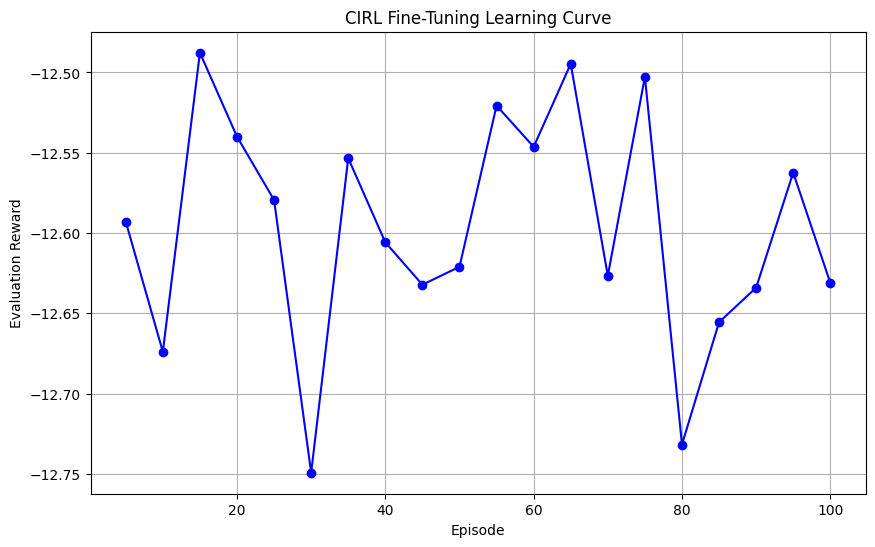

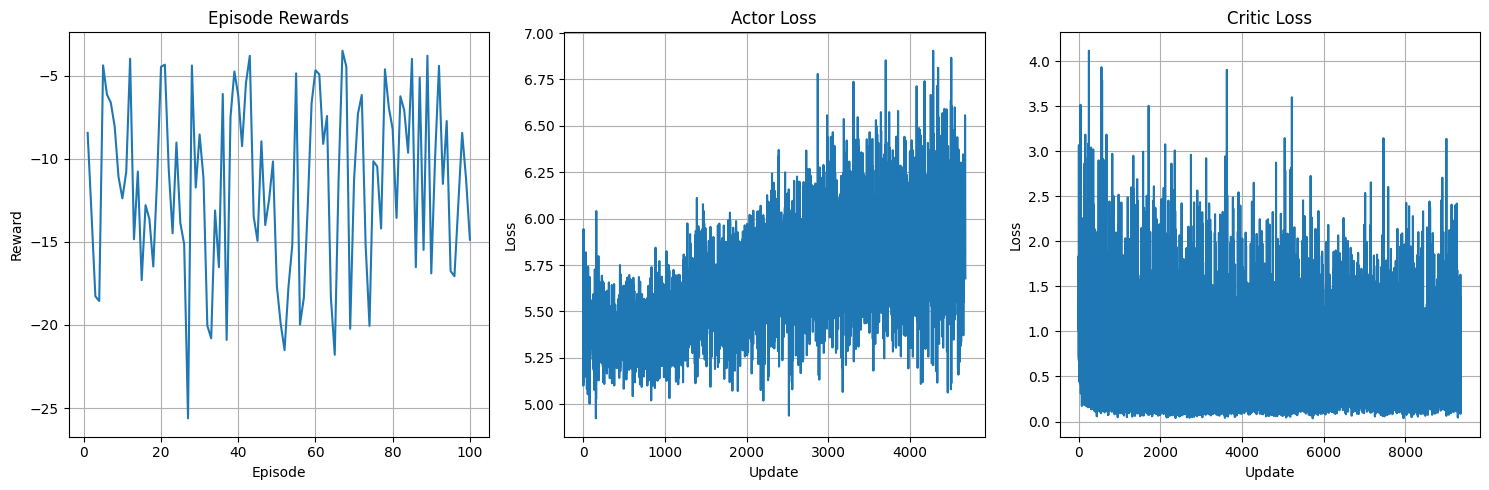

In [3]:
from Train_PSO_CIRL import PSOCIRL
from CSTR_model_plus import CSTRRLEnv
from online_fine_tuning import online_fine_tune
# Fine-tune the agent with online interaction
fine_tune_stats = trainer.fine_tune_online(
    agent=cirl_agent,
    n_episodes=100,
    batch_size=64,
    buffer_size=100000,
    init_exploration=0.3,
    final_exploration=0.1,
    verbose=True
)

In [4]:
# Evaluate the PSO+CIRL agent against static PID
eval_results = trainer.evaluate_and_compare(
    agent=cirl_agent,
    static_pid_path="./results/optimal_pid_gains.npy",
    n_episodes=5,
    verbose=True
)

Evaluating PSO+CIRL agent against baseline static PID...

Evaluating controller: Static PID
  Scenario: Increasing - Setpoints: [0.4, 0.6, 0.8]


    Mean Reward: -6.51 ± 0.03
    Mean MSE: 0.072358 ± 0.000314
  Scenario: Decreasing - Setpoints: [0.9, 0.7, 0.5]
    Mean Reward: -11.72 ± 0.42
    Mean MSE: 0.130275 ± 0.004653
  Scenario: Peak - Setpoints: [0.55, 0.8, 0.55]
    Mean Reward: -6.47 ± 0.07
    Mean MSE: 0.071898 ± 0.000753
  Scenario: Valley - Setpoints: [0.85, 0.6, 0.85]
    Mean Reward: -12.05 ± 0.36
    Mean MSE: 0.133941 ± 0.003967
  Scenario: Step - Setpoints: [0.6, 0.6, 0.8, 0.8]
    Mean Reward: -7.88 ± 0.04
    Mean MSE: 0.087544 ± 0.000424

Evaluating controller: PSO+CIRL
  Scenario: Increasing - Setpoints: [0.4, 0.6, 0.8]
    Mean Reward: -8.99 ± 0.77
    Mean MSE: 0.099911 ± 0.008552
  Scenario: Decreasing - Setpoints: [0.9, 0.7, 0.5]
    Mean Reward: -22.21 ± 0.19
    Mean MSE: 0.246752 ± 0.002116
  Scenario: Peak - Setpoints: [0.55, 0.8, 0.55]
    Mean Reward: -11.29 ± 0.09
    Mean MSE: 0.125498 ± 0.000971
  Scenario: Valley - Setpoints: [0.85, 0.6, 0.85]
    Mean Reward: -21.84 ± 0.05
    Mean MSE: 0.2